<a href="https://colab.research.google.com/github/Shaandili/robotics-me639-2022/blob/Shaandili/ME_639_Assignment_6_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#note: the following code has been written specifically for an R3 planar robot with link lengths = 1m
import math as m
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
#setting desired trajectory
r = np.linspace(-3, 3, 100) #extent is 3, since the maximum extent of the robot is also 3 m from the base
t = np.linspace(0,2*m.pi,100) #for a whole circle
#trajectory for circle with radius 1.5 centered at base - what we desire
xd = 1.5*np.cos(t)
yd = 1.5*np.sin(t)
#matrix for desired trajectory points
Xd = [xd, yd]
#for desired velocity:
xdot = - 1.5*np.sin(t)
ydot = 1.5*np.cos(t)
Xdot = [xdot,ydot]
X = [[0]*len(t),[0]*len(t)]

In [19]:
#user defined function for finding the pseudoinverse of the velocity jacobian
def jvplus (q):
  dh = [[0, q[0], 1, 0],[0, q[1], 1, 0],[0, q[2], 1, 0]] #dh parameters with joint variables for 3R manipulator
  H = [0]*4 #array with link to link transformation matrices
  H[0] = np.identity(4)
  H0 = np.identity(4) #overall transformation matrix
  for i in range(3):
    d = dh[i][0]
    theta = dh[i][1]
    r = dh[i][2]
    alpha = dh[i][3]
    Z = [[m.cos(theta), -1*m.sin(theta), 0, 0], #transforation matrix, Z operations
         [m.sin(theta), m.cos(theta), 0, 0],
         [0, 0, 1, d],
         [0, 0, 0, 1]]
    X = [[1, 0, 0, r], #transforation matrix, X operations
         [0, m.cos(alpha), -1*m.sin(alpha), 0],
         [0, m.sin(alpha), m.cos(alpha), 0],
         [0, 0, 0, 1]]
    H[i+1] = np.matmul(Z,X) #adding current link to link transformation to H matrix
    H0 = H0@H[i+1] #mutliplying link to link transformations to get overall transformation
  on0 = [H0[0][3],H0[1][3],H0[2][3]] #position of last origin (end effector) wrt base
  o = np.zeros(3) #for storing position of end effector wrt current frame
  Jv = np.zeros((2,3)) #jacobian (initialized) (only for lin velocities, not angular)
  h = np.identity(4) #matrix representing transformation from base to current frame
  for i in range(3):
    h = h@H[i]
    z = [h[0][2], h[1][2], h[2][2]] #z -> last column of rotation
    oi0 = [h[0][3], h[1][3], h[2][3]] #position of current frame origin wrt base origin
    #calculation of o:
    o[0] = on0[0] - oi0[0] 
    o[1] = on0[1] - oi0[1]
    o[2] = on0[2] - oi0[2]
    zxoi = (z[1]*o[2]) - (o[1]*z[2]) 
    zxoj = (o[0]*z[2]) - (z[0]*o[2])
    zxok = (z[0]*o[1]) - (o[0]*z[1])
    zxo = [zxoi, zxoj, zxok] #cross product of z and o
    Jv[0][i] = zxo[0]
    Jv[1][i] = zxo[1]
    # Jv[2][i] = zxo[2]
  Jvt = np.transpose(Jv)
  Jvplus = Jvt@np.linalg.inv(Jv@Jvt)
  return Jvplus

In [87]:
#input initial conditions:
x0 = float(input())
y0 = float(input())
#add to matrix of actual values
X[0][0] = x0
X[1][0] = y0
#assuming orientation of initial position is 2*PI
#inverse kinematics for initial joint conditions:
x2 = x0 - 1
y2 = y0
q20 = m.acos((x2**2 + y2**2 - 2)/2)
q10 = m.atan(y2/x2) - m.atan(m.sin(q20)/(1+m.cos(q20)))
q30 = 2*m.pi - (q10 + q20)
q0 = [q10,q20,q30]
#matrix with all q values
q = [0]*len(t)
q[0] = q0
q1d0 = -1.3181160717
q2d0 = 2*m.pi - 2*q1d0
q3d0 = q1d0
qd0 = [q1d0, q2d0, q3d0]


1.5
0


In [88]:
kp = 4 #stiffness constant for error

In [80]:
for k in range(len(t)):
  #calculating current x,y values from current q values
  X[0][k] = m.cos(q[k][0]+q[k][1]+q[k][2]) + m.cos(q[k][0]+q[k][1]) + m.cos(q[k][0])
  X[1][k] = m.sin(q[k][0]+q[k][1]+q[k][2]) + m.sin(q[k][0]+q[k][1]) + m.sin(q[k][0])
  #finding error in position
  ex = [Xd[0][k] - X[0][k], Xd[1][k] - X[1][k]]
  xdot = [Xdot[0][k],Xdot[1][k]]
  #finding pseudoinverse of velocity jacobian for current q values
  Jvp = jvplus(q[k])
  term1 = Jvp@xdot
  term2 = Jvp@ex
  delq = term1 + kp*term2
  #finding the next position of the robot
  q[k+1] = q[k]+ delq

0
1
2
3


IndexError: ignored

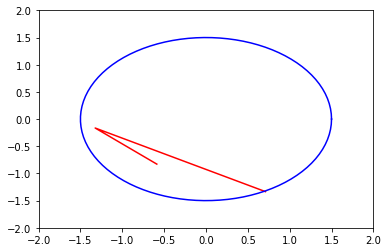

In [84]:
x = np.cos(q[0]+q[1]+q[2]) + np.cos(q[0]+q[1]) + np.cos(q[0])
y = np.sin(q[0]+q[1]+q[2]) + np.sin(q[0]+q[1]) + np.sin(q[0])
X = [x,y]
plt.plot(x,y, color = 'red',label = 'actual') #actual path 
plt.plot(xd,yd, color = 'blue', label = 'desired') #desired path
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()